# DAY 53

## 一、 GAN对抗生成网络思想

先说一下gan的原理，我们之前就说过，无论是多么复杂的架构设计，你最需要把握的核心点就是：1. 损失从何而来 2. 损失如何定义

假设现在有1个造假币的a，和一个警察b，他们都是初始化的神经网络

为了让警察能分辨真币，我需要给他看真币的样子，也就是先训练警察知道什么是真币，但是只给他一个真币他也没法训练，我中间得掺杂一些无意义的噪声图片，无意义的肯定不可能是真币，所以他大概可以训练好。此时他就是一个基础的分类模型，能分别真币和假币

然后我随机初始化这个造假币的a，我每次给他随机的输入，他会生成不同的假币，每一张假币都会让警察来判断，警察能够分别出真假，如果说你是假的，那么造假币的就要更新参数，如果是真的，那么造假币的参数就不用更新，警察要更新参数。所以后续二者就在不断博弈中进步，知道最后假币专家造假以假乱真，只要更新的轮数多，即使骗不过专家，但是也很棒了。

我们把这个造假币的叫做生成器，把这个警察叫做判别器

这个过程有点类似于二者互相对抗，所以叫做对抗生成网络，目的就是在对抗中找到一个可以模仿原有数据的模型。生成器基于随机噪声生成样本，判别器对样本（真实数据 + 生成数据）进行分类，双方根据判别结果更新参数（生成器尝试让判别器误判，判别器尝试提高准确率）。

他的损失由2部分构成，生成器的损失和判别器的损失。判别器的损失定义在先，生成器的损失定义基于判别器的反馈。
1. 判别器的损失：就是分类问题的损失，二分类是二元交叉熵损失BCE（本质分类输出的是概率，并不是非黑即白）

2. 生成器的损失：依靠判别器的损失，如果判别器说是假的，生成器的损失就大，反之亦然。

判别器损失同时包含 “真实数据判真” 和 “生成数据判假” 两部分，而生成器损失仅针对 “生成数据被判别为真” 的目标。实际训练中，两者的优化是交替进行的（先训判别器，再训生成器）。两者的损失共同推动 GAN 逼近 “以假乱真” 的平衡状态。

日常中，我们经常遇到不平衡数据中某一类别样本过少，之前说过结构化数据有smote等过采样方式来提高，图像数据可以数据增强，还可以设置权重等方式来

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# 设置中文字体支持
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

LATENT_DIM = 10     # 潜在空间的维度，这里根据任务复杂程度任选
EPOCHS = 10000      # 训练的回合数，一般需要比较长的时间
BATCH_SIZE = 32     # 每批次训练的样本数
LR = 0.0002         # 学习率
BETA1 = 0.5         # Adam优化器的参数

# 检查是否有可用的GPU，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. 加载并预处理数据 ---

iris = load_iris()
X = iris.data
y = iris.target

# 只选择 'Setosa' (类别 0)
X_class0 = X[y == 0] # 一种简便写法

# 数据缩放到 [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1)) 
X_scaled = scaler.fit_transform(X_class0) 
 
# 转换为 PyTorch Tensor 并创建 DataLoader
# 注意需要将数据类型转为 float
real_data_tensor = torch.from_numpy(X_scaled).float() 
dataset = TensorDataset(real_data_tensor)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"成功加载并预处理数据。用于训练的样本数量: {len(X_scaled)}")
print(f"数据特征维度: {X_scaled.shape[1]}")

使用设备: cuda
Using device: cuda
成功加载并预处理数据。用于训练的样本数量: 50
数据特征维度: 4


## 二、 生成器

In [4]:
# --- 3. 构建模型 ---

# (A) 生成器 (Generator)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(LATENT_DIM, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 4),# 最后的维度只要和目标数据对齐即可
            nn.Tanh() # 输出范围是 [-1, 1]
        )

    def forward(self, x):
        return self.model(x) # 因为没有像之前一样做定义x=某些东西，所以现在可以直接输出模型

### 2.1 nn.Sequential容器

这里我们用了torch中的容器这个概念，sequential是一个按顺序存放神经网络的容器，这样写神经网路的属性的时候，把这些内容都写在一个容器中，然后作为属性，后面定义前向传播的视时候会方便很多。

除了nn.sequential这种按顺序运算的容器,还有一些其他的容器，比如nn.ModuleList对于消融实验会起到简化代码的作用，有机会我们未来再说。

这种写法很好用，比如像encoder-decoder架构（之前复试课说了），就可以借助这种写法来实现简单的定义前向传播

In [5]:
# def forward(self, x):
#     x = self.encoder(x)
#     x = self.decoder(x)
#     return x

当网络结构不满足线性顺序执行时（如包含残差连接、多分支、条件判断等），必须手动编写forward()方法。例如：

In [6]:
# def forward(self, x):
#     identity = x
#     out = self.conv1(x)
#     out = self.relu(out)
#     out = self.conv2(out)
#     out += identity  # 残差连接（无法用Sequential实现）
#     return self.relu(out)

这是一个残差连接的写法，无法用sequential这个容器按顺序搭建。

总结：

- 对于网络层按线性顺序堆叠（如 MLP、CNN 的主体部分），可以使用 Sequential 模型。
- 对于网络包含复杂分支结构（如 ResNet 的残差连接、Inception 的多分支），建议手动编写forward()方法。

这两种方式本质上是等价的，但前者更符合模块化编程的思想，能让你的代码更易读、易维护。

不得不说，代码其实本质上就是几个常见的运算，但是由于不断封装，具备了各种各样的类、属性、语法糖等等写法。

## 三、判别器

In [7]:
# (B) 判别器 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 32),
            nn.LeakyReLU(0.2), # LeakyReLU 是 GAN 中的常用选择
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2), # 负斜率参数为0.2
            nn.Linear(16, 1), # 这里最后输出1个神经元,所以用sigmoid激活函数
            nn.Sigmoid() # 输出 0 到 1 的概率
        )

    def forward(self, x):
        return self.model(x)

### 3.1 分类问题激活函数和损失函数的对应

之前这里说的比较浅，我们再概括下激活函数和损失函数对应的情况：

二分类问题,常见的输出有2种


1. 单输出 + Sigmoid
2.  双输出 + Softmax


二者完全等价,一般推荐第一个

sigmoid一般对应BCE损失，softmax一般对应 CrossEntropy 损失

### 3.2 LeakyReLU

此外，在昨天的神经网络调参指南中，我们就说到了激活函数的选取，我说还有了LeakyReLU这种形式

标准relu: f(x) = max(0, x)  小于0的输入直接置为0,计算简单，能缓解梯度消失问题，引入非线性。存在 “神经元死亡” 问题（当输入为负时，梯度为 0，参数无法更新）

LeakyReLU: f(x) = max(0.01x, x)   对负数输入保留一个小的梯度（如0.01倍）,在输入为负时，仍有非零梯度（如 0.01），避免神经元永久死亡


许多 GAN 变体（如 DCGAN、WGAN）都默认使用 LeakyReLU，实践证明它能显著提高模型收敛速度和生成质量。

In [8]:
# 实例化模型并移动到指定设备
generator = Generator().to(device)
discriminator = Discriminator().to(device)

print(generator)
print(discriminator)

# --- 4. 定义损失函数和优化器 ---

criterion = nn.BCELoss() # 二元交叉熵损失

# 分别为生成器和判别器设置优化器
g_optimizer = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, 0.999))


Generator(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
    (5): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [ ]:

# --- 5. 执行训练循环 ---

print("\n--- 开始训练 ---")
for epoch in range(EPOCHS):
    for i, (real_data,) in enumerate(dataloader):
        # 将数据移动到设备
        real_data = real_data.to(device)
        current_batch_size = real_data.size(0)

        # 创建真实和虚假的标签
        real_labels = torch.ones(current_batch_size, 1).to(device)
        fake_labels = torch.zeros(current_batch_size, 1).to(device)

        # ---------------------
        #  训练判别器
        # ---------------------
        d_optimizer.zero_grad() # 梯度清零

        # (1) 用真实数据训练
        real_output = discriminator(real_data)
        d_loss_real = criterion(real_output, real_labels)
        
        # (2) 用假数据训练
        noise = torch.randn(current_batch_size, LATENT_DIM).to(device)
        # 使用 .detach() 防止在训练判别器时梯度流回生成器，这里我们未来再说
        fake_data = generator(noise).detach() 
        fake_output = discriminator(fake_data)
        d_loss_fake = criterion(fake_output, fake_labels)
        
        # 总损失并反向传播
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # ---------------------
        #  训练生成器
        # ---------------------
        g_optimizer.zero_grad() # 梯度清零

        # 生成新的假数据，并尝试"欺骗"判别器
        noise = torch.randn(current_batch_size, LATENT_DIM).to(device)
        fake_data = generator(noise)
        fake_output = discriminator(fake_data)
        
        # 计算生成器的损失，目标是让判别器将假数据误判为真(1)
        g_loss = criterion(fake_output, real_labels)
        
        # 反向传播并更新生成器
        g_loss.backward()
        g_optimizer.step()

    # 每 1000 个 epoch 打印一次训练状态
    if (epoch + 1) % 1000 == 0:
        print(
            f"Epoch [{epoch+1}/{EPOCHS}], "
            f"Discriminator Loss: {d_loss.item():.4f}, "
            f"Generator Loss: {g_loss.item():.4f}"
        )

print("--- 训练完成 ---")


--- 开始训练 ---
Epoch [1000/10000], Discriminator Loss: 1.2934, Generator Loss: 0.8093
Epoch [2000/10000], Discriminator Loss: 1.3146, Generator Loss: 0.7411
Epoch [3000/10000], Discriminator Loss: 1.3665, Generator Loss: 0.7093
Epoch [4000/10000], Discriminator Loss: 1.3775, Generator Loss: 0.6901
Epoch [5000/10000], Discriminator Loss: 1.3592, Generator Loss: 0.6998
Epoch [6000/10000], Discriminator Loss: 1.3706, Generator Loss: 0.7035
Epoch [7000/10000], Discriminator Loss: 1.3499, Generator Loss: 0.7026
Epoch [8000/10000], Discriminator Loss: 1.3553, Generator Loss: 0.7325
Epoch [9000/10000], Discriminator Loss: 1.3449, Generator Loss: 0.7348
Epoch [10000/10000], Discriminator Loss: 1.3182, Generator Loss: 0.7244
--- 训练完成 ---



--- 生成并可视化结果 ---


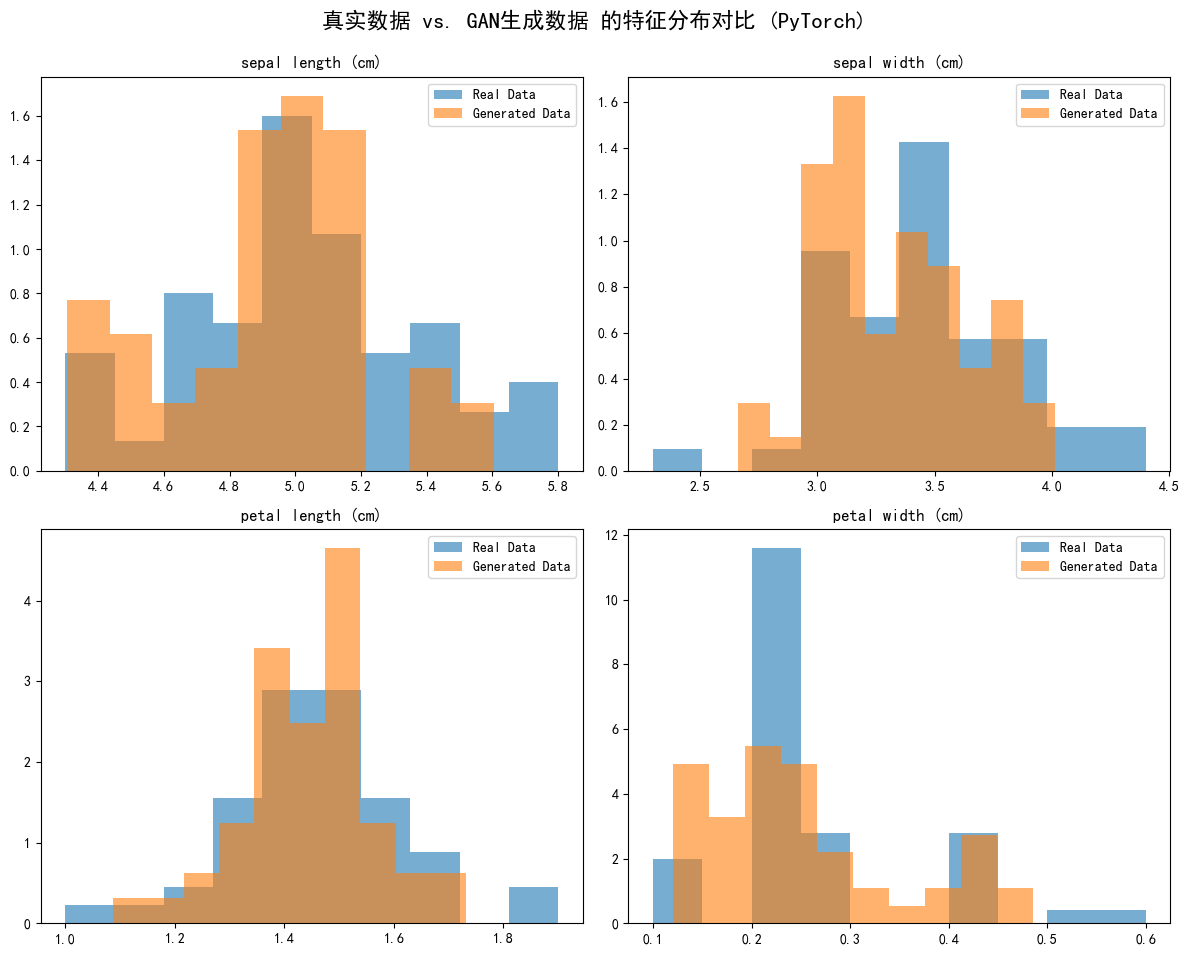


前5个真实样本 (Setosa):
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

GAN生成的5个新样本:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0           4.320492          2.661918           1.386190          0.242133
1           4.977553          3.303130           1.497289          0.186877
2           4.926282          3.197162           1.510863          0.170230
3           4.305457          2.951858           1.087415          0.149636
4           5.188134          3.727965           1.434129          0.220814


In [10]:
# --- 6. 生成新数据并进行可视化对比 ---

print("\n--- 生成并可视化结果 ---")
# 将生成器设为评估模式
generator.eval()

# 使用 torch.no_grad() 来关闭梯度计算
with torch.no_grad():
    num_new_samples = 50
    noise = torch.randn(num_new_samples, LATENT_DIM).to(device)
    generated_data_scaled = generator(noise)

# 将生成的数据从GPU移到CPU，并转换为numpy数组
generated_data_scaled_np = generated_data_scaled.cpu().numpy()

# 逆向转换回原始尺度
generated_data = scaler.inverse_transform(generated_data_scaled_np)
real_data_original_scale = scaler.inverse_transform(X_scaled)

# 可视化对比
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('真实数据 vs. GAN生成数据 的特征分布对比 (PyTorch)', fontsize=16)

feature_names = iris.feature_names

for i, ax in enumerate(axes.flatten()):
    ax.hist(real_data_original_scale[:, i], bins=10, density=True, alpha=0.6, label='Real Data')
    ax.hist(generated_data[:, i], bins=10, density=True, alpha=0.6, label='Generated Data')
    ax.set_title(feature_names[i])
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 将生成的数据与真实数据并排打印出来看看
print("\n前5个真实样本 (Setosa):")
print(pd.DataFrame(real_data_original_scale[:5], columns=feature_names))

print("\nGAN生成的5个新样本:")
print(pd.DataFrame(generated_data[:5], columns=feature_names))



GAN 训练效果的关键指标是 生成数据分布与真实数据分布的重合度：  
- 若两者分布高度重叠 → 生成数据质量高，GAN 学得好  
- 若分布差异大、峰谷错位明显 → 生成数据存在偏差，GAN 学习不充分  

那么如何评价好这个分布情况呢？最好是采取定量指标：KL散度，我们以后有机会再说，主要还使用在图像数据上的，GAN